# Import Dataset for First Check

In [1]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
from scipy.stats import norm, skew
import seaborn as sns
import warnings
import matplotlib.gridspec as gridspec
import matplotlib as mpl
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler 
warnings.filterwarnings("ignore")
%matplotlib inline

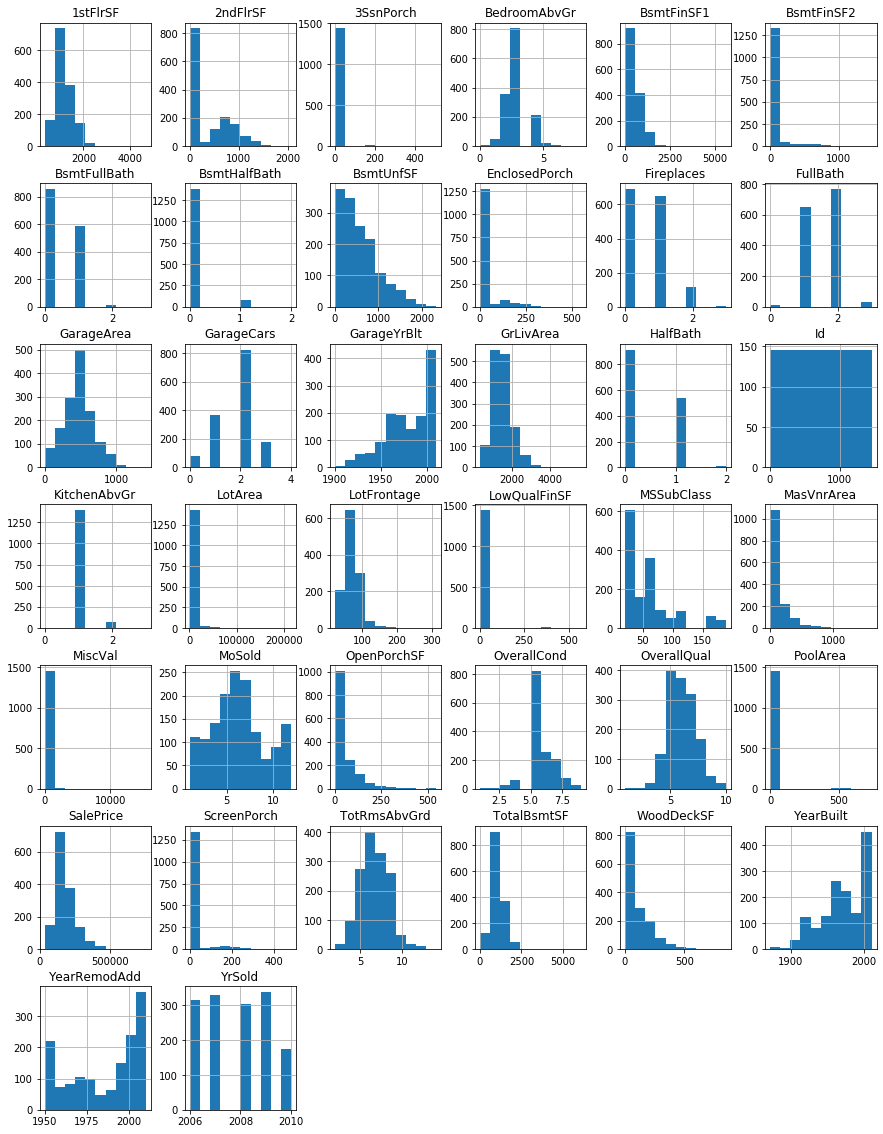

In [2]:
h_price = pd.read_csv('./original_dataset/train.csv')
h_price_test = pd.read_csv('./original_dataset/test.csv')
h_price.hist(figsize=(15,20))
plt.show()

# Target Feature Transformation

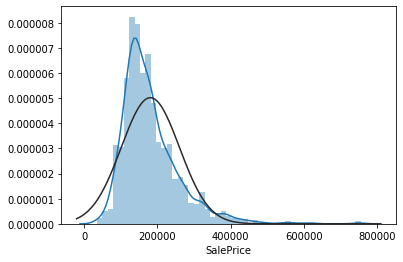

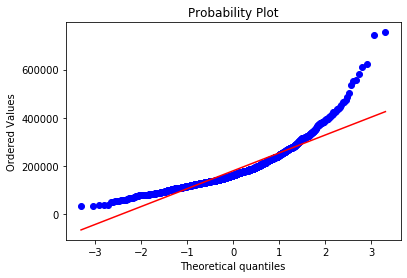

In [3]:
# normalirity check
# check the histgram and probplot to see whether the target feature is normal distributed
sns.distplot(h_price['SalePrice'], fit=norm)
fig = plt.figure()
pro = stats.probplot(h_price['SalePrice'], plot=plt)

Now the histplot and proplot look much better!


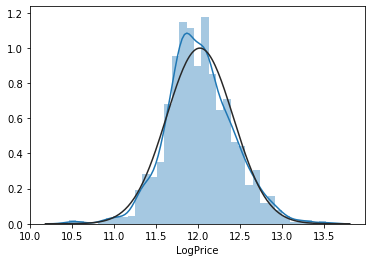

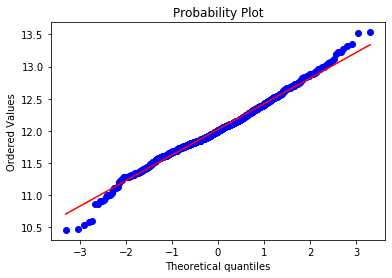

In [4]:
# feature transformation
# since the probplot look like log distribution, we can transform it by np.log()
h_price['LogPrice'] = np.log(h_price['SalePrice'])
print("Now the histplot and proplot look much better!")
dist_price = sns.distplot(h_price['LogPrice'], fit=norm)
fig = plt.figure()
pro_log = stats.probplot(h_price['LogPrice'], plot=plt)
plt.show()

# Correlation Check and Remove the Outliers

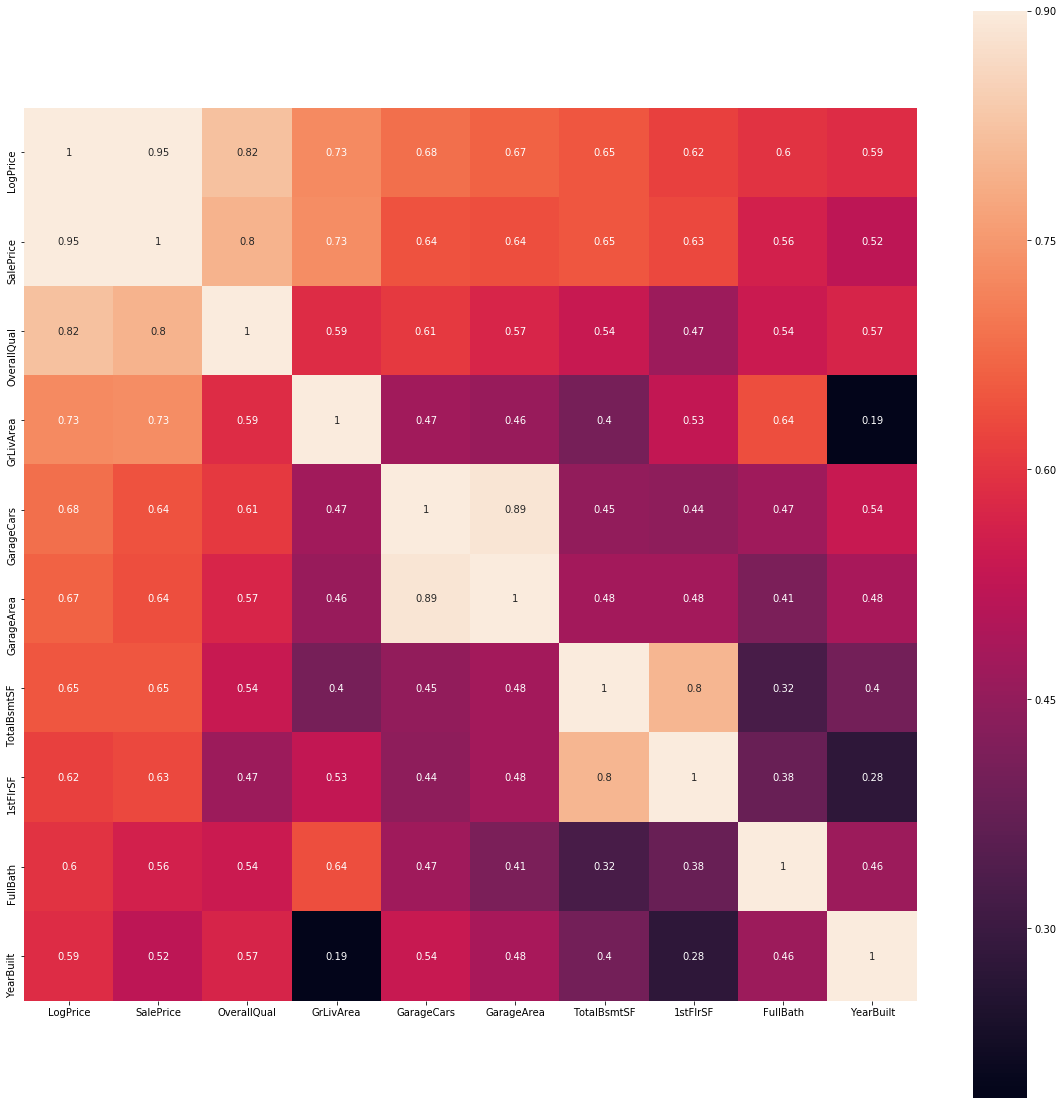

In [427]:
#correlation check for each feature with target feature and plot the first ten high corr features
h_price['GarageYrBlt'] = h_price['GarageYrBlt'].astype('float64')
conti_corre = h_price.corr()
plt.subplots(figsize=(20,20))
cols = conti_corre.nlargest(10, 'LogPrice')['LogPrice'].index
cm = np.corrcoef(h_price[cols].values.T)
sns.heatmap(cm, vmax=0.9,annot=True, square=True,annot_kws={'size': 10},
           yticklabels=cols.values, xticklabels=cols.values)

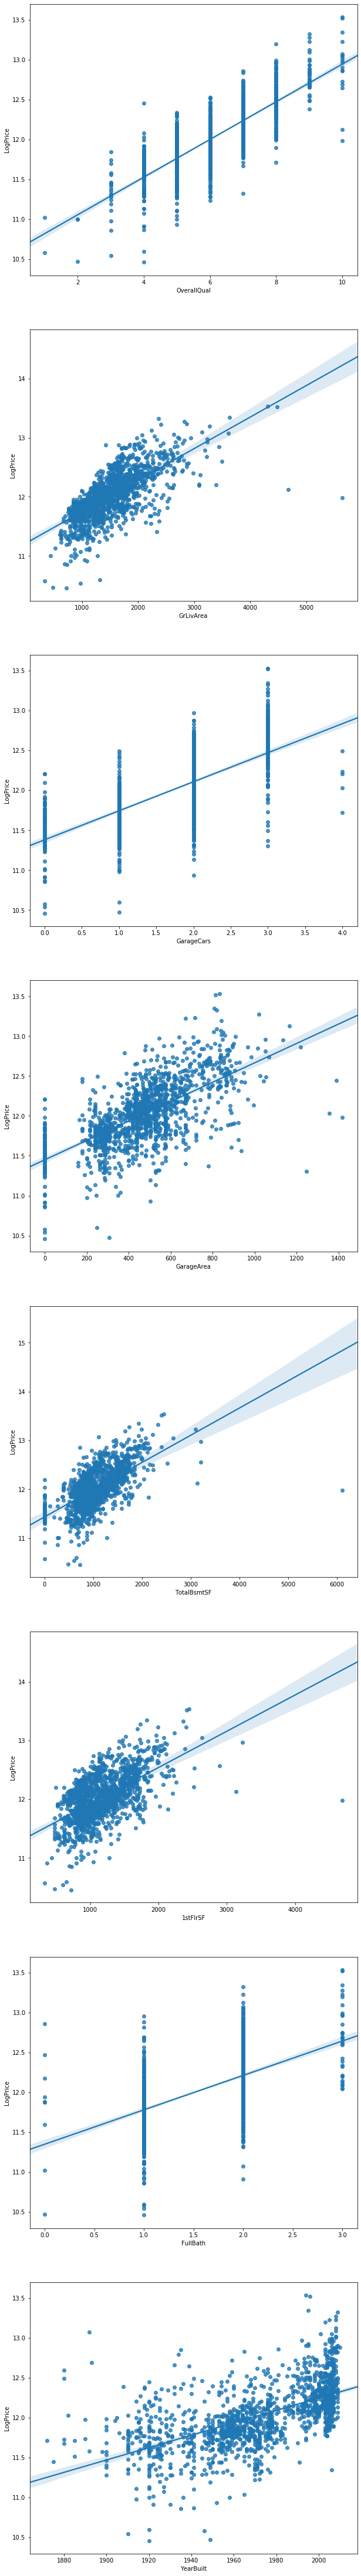

In [6]:
#Removing outliers based on highly correlated features:
major_feature = list(cols)[2:10]
gs2 = gridspec.GridSpec(len(major_feature), 1)
fig = plt.figure(figsize=(10, 80))
j = 0
for feature in major_feature:
    ax1 = plt.subplot(gs2[j, 0])
    sns.regplot(h_price[feature], h_price['LogPrice'], ax= ax1)
    j += 1
#based on the regplot, we can drop two outliers, and then test the corr of all features with price, 
#correlations are increased after removing these two outliers
h_price = h_price.drop(h_price[(h_price['GrLivArea']>4000) & (h_price['SalePrice']<300000)].index)
h_price = h_price.drop(h_price[(h_price['OverallQual']==4) & (h_price['LogPrice']>12.2)].index)
h_price = h_price.drop(h_price[(h_price['GarageArea']>1200) & (h_price['LogPrice']<12.2)].index)
h_price = h_price.drop(h_price[(h_price['GrLivArea']<1500) & (h_price['LogPrice']<10.7)].index)
r_train = h_price.shape[0]

# Missingness imputation

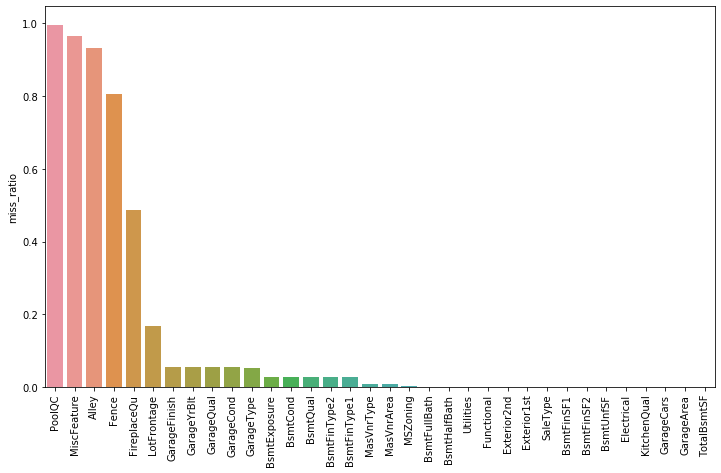

In [412]:
# check the missness ratio
plt.figure(figsize= (12,7))
plt.xticks(rotation='90')
# we combine the train dataset and test dataset together to hadling missness
attri = pd.concat([h_price.iloc[:,1:80], h_price_test.iloc[:,1:]], axis= 0, join = 'outer', ignore_index=True)
col_na = attri.loc[:,attri.isna().any()]
mis_ratio = pd.DataFrame((col_na.isna().sum()/col_na.shape[0]).sort_values(ascending = False),
                        columns = ['miss_ratio'])
sns.barplot(mis_ratio.index, mis_ratio.miss_ratio)


In [413]:
# Impute missing value
# We firstly look through the feature describtion and catarized our data as three types

# for these columns, the NAN are missing value, we groupby neighbourhoods and then fill with high frequence value
Type_col = ['Exterior1st', 'Exterior2nd', 'MSZoning','Functional','SaleType','Electrical','GarageYrBlt']
for name in Type_col:
    attri[name] = attri.groupby(['Neighborhood'])[name].transform(lambda x: x.fillna(x.mode()[0]))
    
# the NAN values in these columns represent the 'None' catagory, we replace NAN with 'None' 
None_col = ['Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure','BsmtFinType1',
           'BsmtFinType2','FireplaceQu', 'GarageFinish','GarageQual',
           'GarageType', 'GarageCond', 'PoolQC', 'Fence','MiscFeature','KitchenQual']
for name in None_col:
    attri[name] = attri[name].fillna('None')

# for these columns, NAN means 0
Zero_col = ['MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','BsmtFullBath',
           'BsmtHalfBath','GarageCars','GarageArea']
for name in Zero_col:
    attri[name] = attri[name].fillna(0)

attri['LotFrontage'] = attri.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))


# Feature Engineering

### make change drop PoolQc but not LowQualFinSF

In [414]:
# add one feature which represents the total square feet of the house
attri['TotalSF'] = attri['TotalBsmtSF'] + attri['1stFlrSF'] + attri['2ndFlrSF']

# drop the useless features: ID, Utilities, Yrsold and LowQualFinSF
attri.drop(['Utilities'], axis = 1, inplace = True)
attri.loc[attri['PoolArea']>0,'PoolArea'] = 1

# classify the catagorical features and continurous features
conti = ['LotFrontage', 'LotArea', 'MasVnrArea','BsmtFinSF1','LowQualFinSF',
         'BsmtFinSF2','BsmtUnfSF','TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
         'GrLivArea','Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 
         'OpenPorchSF', 'EnclosedPorch','3SsnPorch', 'ScreenPorch', 'MiscVal','MoSold',
         'YearRemodAdd','TotalSF','BedroomAbvGr','TotRmsAbvGrd','YearBuilt','GarageYrBlt']

# quantical catagorical data
quant = ['Street','CentralAir','Alley','PoolArea', 'LandContour','LotShape',
         'LandSlope','BldgType', 'MasVnrType','SaleType', 'MiscFeature','Fence', 
          'SaleCondition','PoolArea']

#ordi means the catagorical data which can be impute by numbers and treat as numerical data
ordi = ['OverallQual','OverallCond','ExterCond','ExterQual','BsmtQual',
        'BsmtCond', 'BsmtExposure','HeatingQC','KitchenQual','FireplaceQu',
        'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive',
        'BsmtFinType1','BsmtFinType2']

# nominal catagorical data
nomi = ['MSSubClass', 'MSZoning','LotConfig', 'Neighborhood','Condition1',
        'Condition2', 'BldgType','HouseStyle', 'RoofStyle', 'RoofMatl',
        'Exterior1st', 'Exterior2nd','Foundation','Heating','Functional',
        'GarageType','BsmtFullBath','BsmtHalfBath', 'FullBath',
        'HalfBath', 'KitchenAbvGr','Electrical','PoolQC','YrSold']

for name in conti:
    attri[name] = attri[name].astype('float64')
    
for name in ordi:
    attri.loc[attri[name] == 'GLQ', name] = 12
    attri.loc[attri[name].isin(['Ex','ALQ']), name] = 10
    attri.loc[attri[name].isin(['Gd','GdPrv','BLQ']), name] = 8
    attri.loc[attri[name].isin(['TA','Av','MnPrv','Fin','Rec','Y']), name] = 6
    attri.loc[attri[name].isin(['Fa','Mn','GdWo','RFn','LwQ','P']), name] = 4
    attri.loc[attri[name].isin(['Po','No','MnWw','Unf','N']), name] = 2
    attri.loc[attri[name] == 'None', name] = 0

conti_feature = conti + ordi
for name in (nomi + quant):
    attri[name] = attri[name].astype('str')
#catagorical data cleaning before dummifying
RoofM_other = ['Membran','ClyTile', 'Metal', 'Roll', 'WdShngl','WdShake']
attri.loc[attri['RoofMatl'].isin(RoofM_other),'RoofMatl'] = 'others'
#attri.loc[attri['PoolQC'].isin(['Ex','Gd', 'Fa']),'PoolQC'] = 'Have_Pool'

attri.loc[attri['Condition2'].isin(['RRAn','RRAe']),'Condition2'] = 'Norm'
attri.loc[attri['Condition2'].isin(['RRNn','Artery','Feedr']),'Condition2'] = 'Other'
attri.loc[attri['Condition2'].isin(['PosA','PosN']),'Condition2'] = 'Pos'
attri.loc[attri['Heating'].isin(['Wall','OthW','Floor']),'Heating'] = 'other'
attri.loc[attri['MiscFeature'].isin(['TenC','Othr','Gar2']),'MiscFeature'] = 'other'
# dummify catagorical features
attri = pd.get_dummies(attri)

In [415]:
#check the attri shape and chaek out the NA values
print(attri.shape)
attri.loc[:,attri.isna().any()].head()


(2909, 263)


""
0
1
2
3
4


# Find Skew Feature and use Boxcox to transform features

In [416]:
skewness = attri[conti_feature].apply(lambda x: skew(x)).sort_values()
Skew = pd.DataFrame({'Skew':skewness})
Skew = Skew[abs(Skew['Skew'])>0.75]
Skew_col = list(Skew.index)
for name in Skew_col:
    sk0 = abs(skew(attri[name]))
    sk1 = abs(round(skew(np.log(attri[name]+1)),2))
    if sk1<sk0:
        attri[name] = np.log(attri[name]+1)
        sk2 = abs(skew(np.log(attri[name]+1)))
        if ((sk1>0.75) and (sk1>sk2)):
            attri[name] = np.log(attri[name]+1)
    elif (name in ['BsmtCond','BsmtQual']):
        attri[name] = np.power(attri[name],2)
    elif (name in ['GarageCond','GarageQual']):
        attri[name] = np.power(attri[name],3)
skewness_after = attri[Skew_col].apply(lambda x: skew(x)).sort_values()
Skew['Skew_Log'] = skewness_after
Skew = Skew[abs(Skew['Skew_Log'])>0.75]
print(Skew)

                    Skew  Skew_Log
PavedDrive     -2.996180 -2.996180
BsmtUnfSF       0.918694  0.918694
LotFrontage     1.102316 -1.072827
BsmtFinType2    3.147874 -1.085226
ScreenPorch     3.938725  2.915270
EnclosedPorch   4.010200  1.904747
BsmtFinSF2      4.137937  2.375989
3SsnPorch      11.356127  8.726202
LowQualFinSF   12.067635  8.395317
MiscVal        21.919304  5.084193


# Model Evaluation and Model Selection

In [417]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import sklearn.model_selection as ms
from sklearn.model_selection import train_test_split,KFold,cross_val_score
from sklearn.metrics import mean_squared_error,accuracy_score
from sklearn.ensemble import RandomForestRegressor,GradientBoostingClassifier, GradientBoostingRegressor
import matplotlib.pyplot as plt
import matplotlib
from scipy.special import boxcox1p

train = attri.iloc[:r_train,]
test = attri.iloc[r_train:,]
train.shape

(1450, 263)

## Model 1. Lasso Regression and Feature Selection

RMSE Min: 0.1075
Optimal Lambda: 9.33e-05


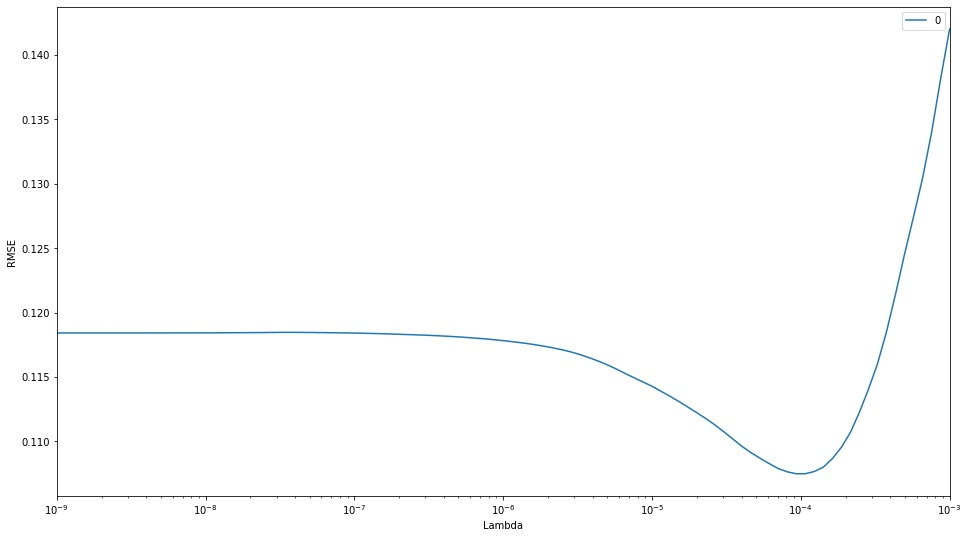

In [418]:
#Tune the lambda(alpha)
matplotlib.rcParams['figure.figsize'] = (16, 9)
test_error_mean=[]
parameter = {}
alphas_lasso = np.logspace(-9, -3, 100)

for i in alphas_lasso:
    lasso = Lasso(alpha = i, normalize=True)
    kf = KFold(5, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse = np.sqrt(-cross_val_score(lasso, train.values, h_price['LogPrice'], scoring="neg_mean_squared_error", cv = kf))
    test_error_mean.append(np.mean(rmse))
    parameter[test_error_mean[-1]] = i

df_test_mean = pd.DataFrame(test_error_mean, index=alphas_lasso)
df_test_mean.plot(logx=True)
alpha_opt = parameter[min(parameter)]
plt.xlabel('Lambda')
plt.ylabel('RMSE')
print("RMSE Min:",round(min(parameter),4))
print("Optimal Lambda:", round(alpha_opt,7))
plt.savefig('plot.jpg', dpi = 250)


### Feature Selection via Lasso 

<Figure size 1152x648 with 0 Axes>

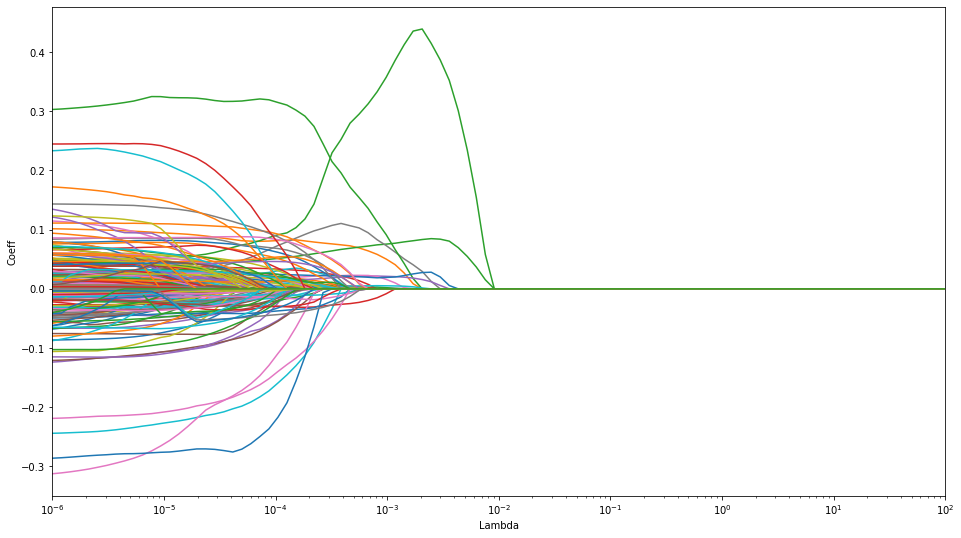

In [184]:
# plot the coef vs alpha
matplotlib.rcParams['figure.figsize'] = (16, 9)
plt.figure(figsize= (16,9))
alphas_lasso = np.logspace(-6, 2, 100)
coef_lasso = []
for i in alphas_lasso:
    lasso.set_params(alpha=i).fit(train, h_price['LogPrice'])
    coef_lasso.append(lasso.coef_)
df_coef = pd.DataFrame(coef_lasso, index=alphas_lasso, columns = train.columns)
df_coef.plot(logx=True, legend = False)
plt.xlabel('Lambda')
plt.ylabel('Coeff')
plt.savefig('lasso_fea.png', dpi = 500)
plt.show()

In [419]:
# Try to find orders of coeffs which reach to 0
parameter = {}
Columns = []
Lasso_coef = []
#plt.figure(figsize= (16,9))
alphas_lasso = np.logspace(-9, -3, 100)
for i in alphas_lasso:
    for j in range(5):
        lasso = Lasso(alpha = i, normalize=True)
        coef_lasso = []
        test_error = []
        x_train, x_test, y_train, y_test = ms.train_test_split(train, h_price['LogPrice'], 
                                                       test_size=1.0/5, random_state=j)
        lasso.set_params(alpha=i).fit(x_train, y_train)
        Lasso_coef.append(lasso.coef_)
        COEF = pd.DataFrame(Lasso_coef, columns =x_train.columns)

COEF =COEF.groupby(np.arange(len(COEF.index))//5).mean()
zero_feature =[]
zero_dict = {}
df_dict = {}
for i in range(100):
    new_feature = []
    df = COEF.loc[[i],]
    zero_feature.append(df.loc[:,(df == 0).any()].columns)
    if i>0:
        for feature in zero_feature[i]:
            if (feature in zero_feature[i-1]) == False:
                new_feature.append(feature)
        if new_feature != []:
            zero_dict[i]=new_feature
            for feature in new_feature:
                df_dict[feature] = alphas_lasso[i]
            print(new_feature)
            print('lambda =:', alphas_lasso[i])
            print('*'*100)

['LandContour_Lvl']
lambda =: 1.0722672220103231e-08
****************************************************************************************************
['BsmtFullBath_1.0']
lambda =: 5.72236765935022e-08
****************************************************************************************************
['RoofStyle_Hip']
lambda =: 8.697490026177834e-08
****************************************************************************************************
['MSSubClass_90', 'LotConfig_Inside']
lambda =: 2.009233002565046e-07
****************************************************************************************************
['Heating_GasA']
lambda =: 2.656087782946684e-07
****************************************************************************************************
['LandSlope_Gtl']
lambda =: 3.5111917342151277e-07
****************************************************************************************************
['PoolQC_None']
lambda =: 4.641588833612782e-07
*********************

['MSSubClass_60', 'Neighborhood_MeadowV', 'HouseStyle_1.5Fin', 'Exterior2nd_HdBoard', 'Foundation_Slab', 'Heating_GasW', 'HalfBath_2', 'Functional_Mod', 'GarageType_Basment', 'SaleType_CWD']
lambda =: 0.0001873817422860383
****************************************************************************************************
['MSSubClass_160', 'LandSlope_Mod', 'Neighborhood_ClearCr', 'Neighborhood_Mitchel', 'RoofMatl_Tar&Grv', 'Exterior1st_HdBoard', 'Exterior2nd_ImStucc', 'MasVnrType_BrkCmn', 'Heating_Grav', 'PoolQC_Gd', 'YrSold_2009']
lambda =: 0.00021544346900318867
****************************************************************************************************
['BsmtFinType2', 'PavedDrive', 'Street_Pave', 'Neighborhood_NWAmes', 'RoofStyle_Gable', 'Foundation_Wood', 'BsmtFullBath_2.0', 'Functional_Maj1', 'SaleType_Oth']
lambda =: 0.0002477076355991714
****************************************************************************************************
['Street_Grvl', 'Alley_Grvl', 'A

In [420]:
n_zero_order = np.where(alphas_lasso == alpha_opt)[0][0]
train_2nd = train.copy()
train_2nd.drop(list(zero_feature[n_zero_order]),axis = 1, inplace = True)

In [421]:
test_2nd = test.copy()
test_2nd.drop(list(zero_feature[n_zero_order]),axis = 1, inplace = True)

In [422]:
train_2nd.shape[1]

144

In [423]:
print('Numbers of Features Dropped:', train.shape[1]-train_2nd.shape[1])
feature = df_dict.items()
pd.DataFrame(feature,columns = ['Features','Lambda']).sort_values('Lambda', ascending = True).head(10)

Numbers of Features Dropped: 119


,Features,Lambda
0,LandContour_Lvl,1.072267e-08
1,BsmtFullBath_1.0,5.722368e-08
4,LotConfig_Inside,2.009233e-07
5,Heating_GasA,2.656088e-07
6,LandSlope_Gtl,3.511192e-07
9,MSZoning_RL,1.629751e-06
10,PoolQC_Fa,1.873817e-06
11,Foundation_CBlock,2.154435e-06
12,Alley_None,4.328761e-06
13,Exterior2nd_MetalSd,4.977024e-06


RMSE Min: 0.1071
Optimized lambda: 7.22e-05


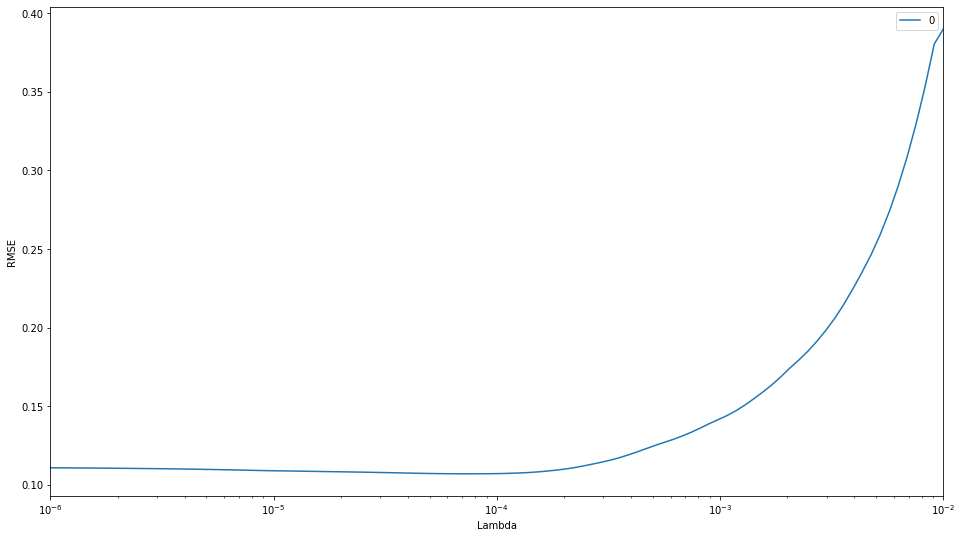

In [197]:
#tune the lambda for updated training dataset(alpha)
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (16, 9)
test_error_mean=[]
parameter = {}
alphas_lasso = np.logspace(-6, -2, 100)
for i in alphas_lasso:
    lasso = Lasso(alpha = i,normalize=True)
    kf = KFold(5, shuffle=True, random_state=42).get_n_splits(train_2nd.values)
    rmse = np.sqrt(-cross_val_score(lasso, train_2nd.values, h_price['LogPrice'], scoring="neg_mean_squared_error", cv = kf))
    test_error_mean.append(np.mean(rmse))
    parameter[test_error_mean[-1]] = i

df_test_mean = pd.DataFrame(test_error_mean, index=alphas_lasso)
df_test_mean.plot(logx=True)
lasso_alpha_opt = parameter[min(parameter)]
plt.xlabel('Lambda')
plt.ylabel('RMSE')
plt.savefig('lasso_afterdrop.jpg',dpi = 250)
lasso_alpha_opt = parameter[min(parameter)]
print("RMSE Min:",round(min(parameter),4))
print("Optimized lambda:", round(lasso_alpha_opt,7))

In [256]:
lasso = Lasso(alpha = 9.33e-5, normalize=True)
kf_ori = KFold(5, shuffle=True, random_state=42).get_n_splits(train.values)
rmse_ori= np.sqrt(-cross_val_score(lasso, train.values, h_price['LogPrice'], scoring="neg_mean_squared_error", cv = kf))





In [257]:
lasso = Lasso(alpha = lasso_alpha_opt, normalize=True)


kf_new = KFold(5, shuffle=True, random_state=42).get_n_splits(train_2nd.values)
rmse_new= np.sqrt(-cross_val_score(lasso, train_2nd.values, h_price['LogPrice'], scoring="neg_mean_squared_error", cv = kf))
lasso_scores_train = ms.cross_val_score(lasso, train.values, h_price['LogPrice'] ,cv=5)
lasso_scores = ms.cross_val_score(lasso, train_2nd.values, h_price['LogPrice'] ,cv=5)
print("R2 before Dropping is:", round(np.mean(lasso_scores_train),4),"/","RMSE before Dropping:",round(np.mean(rmse_ori),5))
print("R2 std before Dropping is:", round(np.std(lasso_scores_train),4),"/","RMSE Std before Dropping:",round(np.std(rmse_ori),5))
print('-'*75)
print("R2 after Dropping is:", round(np.mean(lasso_scores),4),"/","RMSE after Dropping:",round(np.mean(rmse_new),5))
print("R2 std after Dropping is:", round(np.std(lasso_scores),4),"/","RMSE Std after Dropping:",round(np.std(rmse_new),5))


R2 before Dropping is: 0.9233 / RMSE before Dropping: 0.10749
R2 std before Dropping is: 0.0077 / RMSE Std before Dropping: 0.00847
---------------------------------------------------------------------------
R2 after Dropping is: 0.9243 / RMSE after Dropping: 0.1071
R2 std after Dropping is: 0.0079 / RMSE Std after Dropping: 0.00833


## Model 2. Ridge

RMSE Min: 0.1135
optimized lambda: 0.231


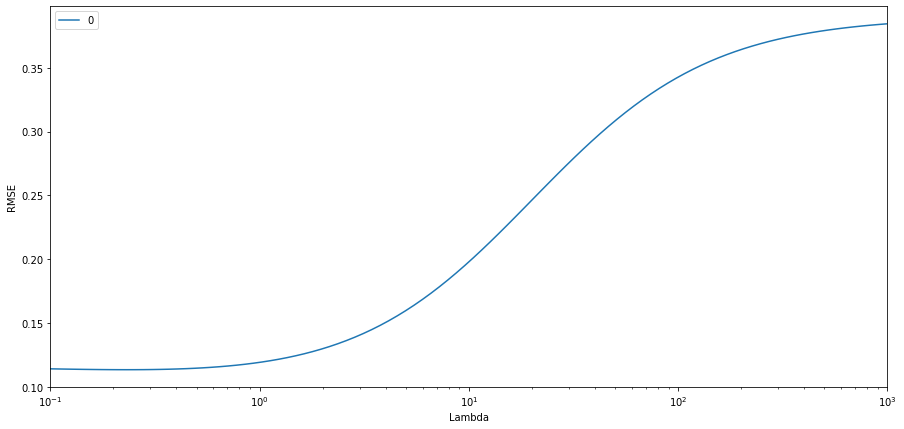

In [252]:
#tune the lambda for updated training dataset(alpha)
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (15,7)
test_error_mean=[]
parameter2 = {}
alphas_ridge = np.logspace(-1, 3, 100)
for i in alphas_ridge:
    ridge = Ridge(alpha = i, normalize=True)
    kf = KFold(5, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse = np.sqrt(-cross_val_score(ridge, train.values, h_price['LogPrice'], scoring="neg_mean_squared_error", cv = kf))
    test_error_mean.append(np.mean(rmse))
    parameter2[test_error_mean[-1]] = i

df_test_mean = pd.DataFrame(test_error_mean, index=alphas_ridge)
df_test_mean.plot(logx=True)
plt.xlabel('Lambda')
plt.ylabel('RMSE')
plt.savefig('ridge.png',dpi = 250)
ridge_alpha_opt2 = parameter2[min(parameter2)]
print("RMSE Min:",round(min(parameter2),4))
print("optimized lambda:", round(ridge_alpha_opt2, 3))

RMSE Min: 0.1091
optimized lambda: 0.145


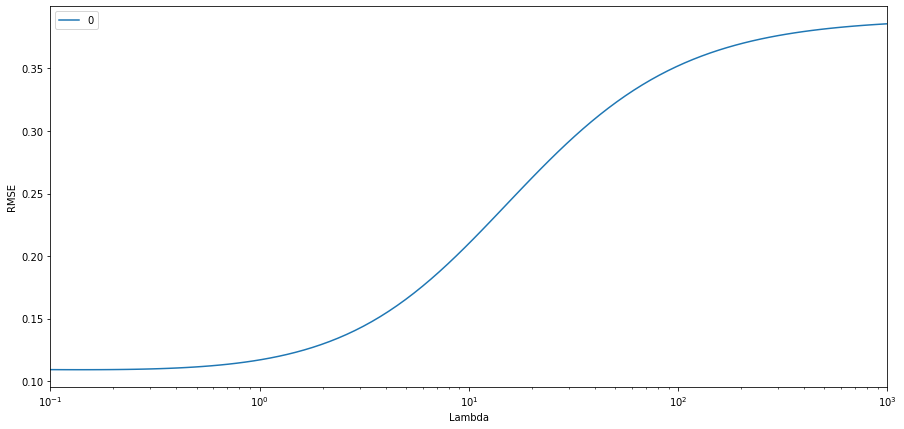

In [253]:
#tune the lambda for updated training dataset(alpha)
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (15,7)
test_error_mean=[]
parameter = {}
alphas_ridge = np.logspace(-1, 3, 100)
for i in alphas_ridge:
    ridge = Ridge(alpha = i, normalize=True)
    kf = KFold(5, shuffle=True, random_state=42).get_n_splits(train_2nd.values)
    rmse = np.sqrt(-cross_val_score(ridge, train_2nd.values, h_price['LogPrice'], scoring="neg_mean_squared_error", cv = kf))
    test_error_mean.append(np.mean(rmse))
    parameter[test_error_mean[-1]] = i

df_test_mean = pd.DataFrame(test_error_mean, index=alphas_ridge)
df_test_mean.plot(logx=True)
plt.xlabel('Lambda')
plt.ylabel('RMSE')
plt.savefig('ridge2.png',dpi = 250)
ridge_alpha_opt = parameter[min(parameter)]
print("RMSE Min:",round(min(parameter), 4))
print("optimized lambda:", round(ridge_alpha_opt, 3))

In [258]:
ridge = Ridge(0.231,normalize=True)
kf_ori = KFold(6, shuffle=True, random_state=42).get_n_splits(train.values)
rmse_ori= np.sqrt(-cross_val_score(ridge, train.values, h_price['LogPrice'], scoring="neg_mean_squared_error", cv = kf))

In [259]:
ridge = Ridge(ridge_alpha_opt,normalize=True) # create a ridge regression instance


kf_new = KFold(6, shuffle=True, random_state=42).get_n_splits(train_2nd.values)
rmse_new= np.sqrt(-cross_val_score(ridge, train_2nd.values, h_price['LogPrice'], scoring="neg_mean_squared_error", cv = kf))
ridge_scores_train = ms.cross_val_score(ridge, train.values, h_price['LogPrice'] ,cv=5)
ridge_scores = ms.cross_val_score(ridge, train_2nd.values, h_price['LogPrice'] ,cv=5)
print("R2 before Dropping is:", round(np.mean(ridge_scores_train),4),"/","RMSE before Dropping:",round(np.mean(rmse_ori),4))
print("R2 std before Dropping is:", round(np.std(ridge_scores_train),4),"/","RMSE Std before Dropping:",round(np.std(rmse_ori),5))
print('-'*75)
print("R2 after Dropping is:", round(np.mean(ridge_scores),4),"/","RMSE after Dropping:",round(np.mean(rmse_new),4))
print("R2 std after Dropping is:", round(np.std(ridge_scores),4),"/","RMSE Std after Dropping:",round(np.std(rmse_new),5))

R2 before Dropping is: 0.9148 / RMSE before Dropping: 0.1135
R2 std before Dropping is: 0.0068 / RMSE Std before Dropping: 0.0094
---------------------------------------------------------------------------
R2 after Dropping is: 0.9216 / RMSE after Dropping: 0.1091
R2 std after Dropping is: 0.0058 / RMSE Std after Dropping: 0.0077


## Model 3. Elastic Regression

In [303]:
#Elastic regression tune alpha
para = {}
alphas_elastic = np.logspace(-6, 0, 120)
for j in alphas_elastic:
    elastic = ElasticNet(alpha = j, l1_ratio = 0.54, random_state=5,normalize=True)
    kf = KFold(5, shuffle=True, random_state=26).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(elastic, train.values, h_price['LogPrice'], scoring="neg_mean_squared_error", cv = kf))
    para[np.mean(rmse)] = j
alpha_opt = para[min(para)]
print("The Optimized Alpha is:", alpha_opt)


The Optimized Alpha is: 0.00014725404276241222


In [304]:
#Elastic regression tune rho
para = {}
for j in np.arange(0,1.0,0.02):
    elastic = ElasticNet(alpha = alpha_opt, l1_ratio = j,random_state=5, normalize=True)
    kf = KFold(5, shuffle=True, random_state=26).get_n_splits(train_2nd.values)
    rmse= np.sqrt(-cross_val_score(elastic, train_2nd.values, h_price['LogPrice'], scoring="neg_mean_squared_error", cv = kf))
    para[np.mean(rmse)] = j
rho_opt = para[min(para)]
print("The Optimized Rho is:", round(rho_opt,2))



The Optimized Rho is: 0.54


In [305]:
elastic = ElasticNet(alpha = alpha_opt, l1_ratio = rho_opt, normalize=True) # create a ridge regression instance

kf_ori = KFold(5, shuffle=True, random_state=42).get_n_splits(train.values)
rmse_ori= np.sqrt(-cross_val_score(elastic, train.values, h_price['LogPrice'], scoring="neg_mean_squared_error", cv = kf))
elas_scores_train = ms.cross_val_score(elastic, train.values, h_price['LogPrice'] ,cv=5)


In [312]:
#Elastic regression tune alpha
para_2nd = {}
alphas_elastic = np.logspace(-6, 0, 150)
for j in alphas_elastic:
    elastic = ElasticNet(alpha = j, l1_ratio = 1, random_state=5,normalize=True)
    kf = KFold(5, shuffle=True, random_state=26).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(elastic, train.values, h_price['LogPrice'], scoring="neg_mean_squared_error", cv = kf))
    para_2nd[np.mean(rmse)] = j
alpha_opt_2nd = para_2nd[min(para_2nd)]
print("The Optimized Alpha is:", alpha_opt_2nd)

The Optimized Alpha is: 0.00010313897683787211


In [314]:
para_2nd = {}
for j in np.arange(0,1.02,0.02):
    elastic = ElasticNet(alpha = alpha_opt_2nd, l1_ratio = j,random_state=5, normalize=True)
    kf = KFold(5, shuffle=True, random_state=26).get_n_splits(train_2nd.values)
    rmse= np.sqrt(-cross_val_score(elastic, train_2nd.values, h_price['LogPrice'], scoring="neg_mean_squared_error", cv = kf))
    para_2nd[np.mean(rmse)] = j
rho_opt_2nd = para_2nd[min(para_2nd)]
print("The Optimized Rho is:", round(rho_opt_2nd,2))

The Optimized Rho is: 1.0


In [315]:
elastic = ElasticNet(alpha = alpha_opt_2nd, l1_ratio = rho_opt_2nd, normalize=True)
kf_new = KFold(5, shuffle=True, random_state=42).get_n_splits(train_2nd.values)
rmse_new= np.sqrt(-cross_val_score(elastic, train_2nd.values, h_price['LogPrice'], scoring="neg_mean_squared_error", cv = kf))
elas_scores = ms.cross_val_score(elastic, train_2nd.values, h_price['LogPrice'] ,cv=5)
print("R2 before Dropping is:", round(np.mean(elas_scores_train),4),"/","RMSE before Dropping:",round(np.mean(rmse_ori),6))
print("R2 std before Dropping is:", round(np.std(elas_scores_train),4),"/","RMSE Std before Dropping:",round(np.std(rmse_ori),6))
print('-'*75)
print("R2 after Dropping is:", round(np.mean(elas_scores),4),"/","RMSE after Dropping:",round(np.mean(rmse_new),6))
print("R2 std after Dropping is:", round(np.std(elas_scores),4),"/","RMSE Std after Dropping:",round(np.std(rmse_new),6))

R2 before Dropping is: 0.9231 / RMSE before Dropping: 0.10799
R2 std before Dropping is: 0.0079 / RMSE Std before Dropping: 0.008935
---------------------------------------------------------------------------
R2 after Dropping is: 0.9241 / RMSE after Dropping: 0.107218
R2 std after Dropping is: 0.0084 / RMSE Std after Dropping: 0.008672


In [211]:
elastic = ElasticNet(alpha = alpha_opt_2nd, l1_ratio = rho_opt_2nd,normalize=True)
elastic.fit(train_2nd.values, h_price['LogPrice'])
ela_predict = elastic.predict(test_2nd)
predict_rid = pd.DataFrame({'Id':range(1461,2920),
                            'SalePrice': np.exp(ela_predict)})
predict_rid.to_csv('ela_predict_drop3.csv',index=False)

## Model 4. GBM

In [336]:
GBoost = GradientBoostingRegressor(n_estimators=2000, learning_rate=0.05,
                                   max_depth=3, max_features='sqrt',
                                   min_samples_leaf=10, min_samples_split=5, 
                                   loss='huber', random_state =26)

kf_ori = KFold(5, shuffle=True, random_state=42).get_n_splits(train.values)
rmse_ori= np.sqrt(-cross_val_score(GBoost, train.values, h_price['LogPrice'], scoring="neg_mean_squared_error", cv = kf))
kf_new = KFold(5, shuffle=True, random_state=42).get_n_splits(train_2nd.values)
rmse_new= np.sqrt(-cross_val_score(GBoost, train_2nd.values, h_price['LogPrice'], scoring="neg_mean_squared_error", cv = kf))
GB_scores_train = ms.cross_val_score(GBoost, train.values, h_price['LogPrice'] ,cv=5)
GB_scores = ms.cross_val_score(GBoost, train_2nd.values, h_price['LogPrice'] ,cv=5)
print("R2 before Dropping is:", round(np.mean(GB_scores_train),4),"/","RMSE before Dropping:",round(np.mean(rmse_ori),6))
print("R2 std before Dropping is:", round(np.std(GB_scores_train),4),"/","RMSE Std before Dropping:",round(np.std(rmse_ori),6))
print('-'*75)
print("R2 after Dropping is:", round(np.mean(GB_scores),4),"/","RMSE after Dropping:",round(np.mean(rmse_new),6))
print("R2 std after Dropping is:", round(np.std(GB_scores),4),"/","RMSE Std after Dropping:",round(np.std(rmse_new),6))

R2 before Dropping is: 0.9229 / RMSE before Dropping: 0.108238
R2 std before Dropping is: 0.0111 / RMSE Std before Dropping: 0.012255
---------------------------------------------------------------------------
R2 after Dropping is: 0.9231 / RMSE after Dropping: 0.108065
R2 std after Dropping is: 0.0109 / RMSE Std after Dropping: 0.011915


In [ ]:
GBoost.fit(train.values, h_price['LogPrice'])
sorted_importance = sorted(zip(train.columns, GBoost.feature_importances_), key=lambda t:t[1], reverse=True)


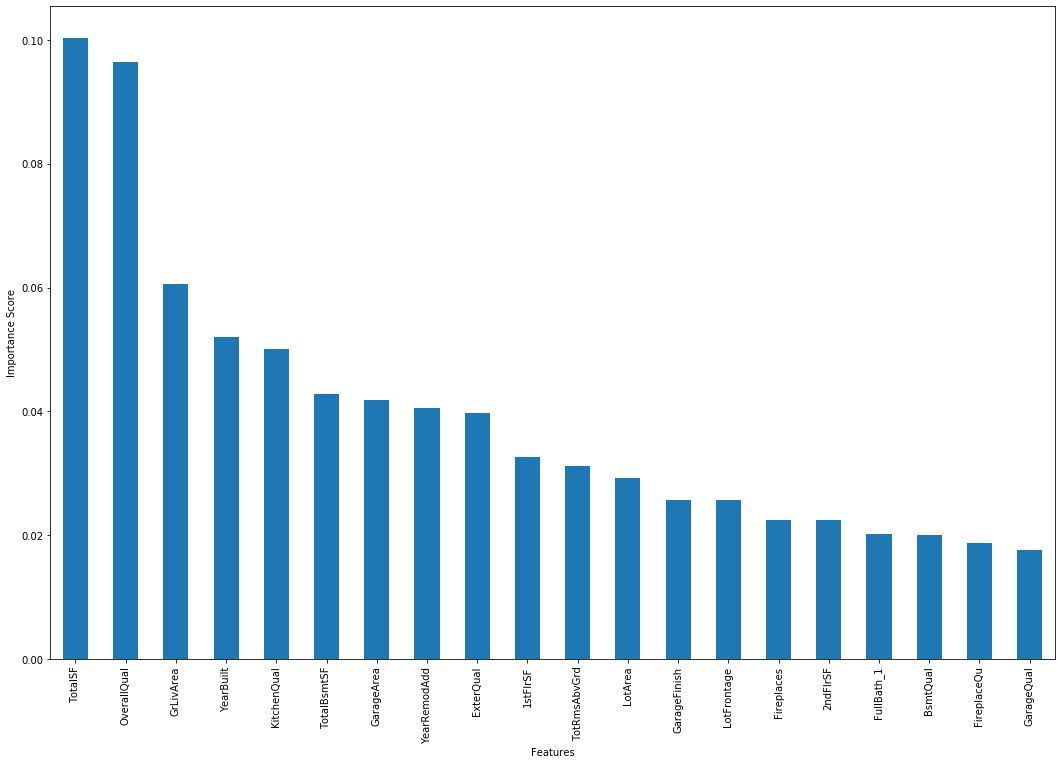

In [214]:
a, b = zip(*sorted_importance) # this splits the list of tuples into two lists
matplotlib.rcParams['figure.figsize'] = (18,12)
pd.DataFrame({'feature_name':a, 'importance_score':b}).head(20).plot.bar(x='feature_name',y='importance_score', legend=None)
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.savefig('Fea_impor.png',dpi = 250)

In [341]:
gboost_drop = list(pd.DataFrame({'feature_name':a, 'importance_score':b}).tail(119).feature_name)

In [404]:
lasso_drop = []

for feature in list(train.columns):
    if (feature in list(train_2nd.columns)) == False:
        lasso_drop.append(feature)
lasso_drop

119

In [397]:
len(list(train_2nd.columns))

144

In [407]:
gboost_drop_df = pd.DataFrame({'feature_name':a, 'importance_score':b})
dic = {}
for feature in lasso_drop:
    dic[feature] = gboost_drop_df.loc[gboost_drop_df['feature_name']==feature,'importance_score'].values[0]
gb = pd.DataFrame(dic.items(), columns = ['feature_name', 'importance_score'])
gb.sort_values(by = 'importance_score', ascending = False).head(15)

,feature_name,importance_score
3,2ndFlrSF,0.022378
92,FullBath_1,0.020209
95,HalfBath_0,0.012514
5,GarageYrBlt,0.011994
93,FullBath_2,0.007853
6,GarageCond,0.006208
99,GarageType_Attchd,0.005253
74,Exterior2nd_VinylSd,0.004791
37,Neighborhood_NAmes,0.004009
79,Foundation_CBlock,0.003179


## Model 5. XGM

In [411]:
import xgboost as xgb

model_xgb = xgb.XGBRegressor(colsample_bytree=0.4003, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2000,
                             reg_alpha=1, reg_lambda=0.5,
                             subsample=0.75, silent=1,
                             random_state =77, nthread = -1)
kf_ori = KFold(5, shuffle=True, random_state=42).get_n_splits(train.values)
rmse_ori= np.sqrt(-cross_val_score(model_xgb, train.values, h_price['LogPrice'], scoring="neg_mean_squared_error", cv = kf))
kf_new = KFold(5, shuffle=True, random_state=42).get_n_splits(train_2nd.values)
rmse_new= np.sqrt(-cross_val_score(model_xgb, train_2nd.values, h_price['LogPrice'], scoring="neg_mean_squared_error", cv = kf))
model_xgb_scores_train = ms.cross_val_score(model_xgb, train.values, h_price['LogPrice'] ,cv=5)
model_xgb_scores = ms.cross_val_score(model_xgb, train_2nd.values, h_price['LogPrice'] ,cv=5)
print("R2 before Dropping is:", round(np.mean(model_xgb_scores_train),4),"/","RMSE before Dropping:",round(np.mean(rmse_ori),6))
print("R2 std before Dropping is:", round(np.std(model_xgb_scores_train),4),"/","RMSE Std before Dropping:",round(np.std(rmse_ori),6))
print('-'*75)
print("R2 after Dropping is:", round(np.mean(model_xgb_scores),4),"/","RMSE after Dropping:",round(np.mean(rmse_new),6))
print("R2 std after Dropping is:", round(np.std(model_xgb_scores),4),"/","RMSE Std after Dropping:",round(np.std(rmse_new),6))

R2 before Dropping is: 0.912 / RMSE before Dropping: 0.115503
R2 std before Dropping is: 0.0112 / RMSE Std before Dropping: 0.011056
---------------------------------------------------------------------------
R2 after Dropping is: 0.9131 / RMSE after Dropping: 0.114821
R2 std after Dropping is: 0.01 / RMSE Std after Dropping: 0.010312


## Stack Regressor

In [235]:
from mlxtend.regressor import StackingCVRegressor
stack = StackingCVRegressor(regressors=(ridge, lasso, elastic, model_xgb, GBoost),
                            meta_regressor=lasso,
                            random_state=46)

In [236]:
Lmse2 = []
for i in range(5):
    x_train, x_test, y_train, y_test = ms.train_test_split(train_2nd, h_price['LogPrice'], 
                                                       test_size=1.0/5, random_state=i)
    stack.fit(x_train.values, y_train)
    rmse = np.sqrt(np.mean((stack.predict(x_test.values)-y_test)**2))
    Lmse2.append(rmse)
print(np.mean(Lmse2))

0.09947403781270972


In [239]:
print('The Final Stack RSME:',round(np.mean(Lmse2),4))
print('The Final Stack RSME Std:',round(np.std(Lmse2),5))

The Final Stack RSME: 0.0995
The Final Stack RSME Std: 0.00576


In [248]:
stack.fit(train_2nd.values, h_price['LogPrice'])
Price_predict = stack.predict(test_2nd.values)
predict = pd.DataFrame({'Id':range(1461,2920),
                            'SalePrice': np.exp(Price_predict)})
predict.to_csv('stack_predict_drop3.csv',index=False)